<a href="https://colab.research.google.com/github/yesavailable/NLP_2024/blob/main/13_SentimentAnalysis_HarryPotter_AllSevenCopiesIncluded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##🐹 🐾 🐟 This script is based on [**Prof. Hosung Nam's github (hsnam95)**](https://github.com/hsnam95) and [**Prof. Junkyu Lee's github (junkyuhufs)**](https://github.com/junkyuhufs)

In [1]:
#@markdown ##🐹 🐾  <font color = 'red'> **[1] 복제하여 Harry Potter자료 가져오기**
!git clone https://github.com/ErikaJacobs/Harry-Potter-Text-Mining.git

Cloning into 'Harry-Potter-Text-Mining'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (109/109), 13.39 MiB | 8.05 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [2]:
#@markdown ##🐹 🐾  <font color = 'blue'> **[2] 데이터 전처리: Pandas이용 데이터 정리 (책의 한 챕터가 한 셀에 있는 상태)**
import pandas as pd #Importing Pandas package
%cd /content/Harry-Potter-Text-Mining/Book Text

import glob
fns = glob.glob('*.txt')
df = pd.DataFrame()
for fn in fns:
  dftmp = pd.read_csv(fn, sep="@")
  df = pd.concat([df, dftmp])

%cd /content

df

/content/Harry-Potter-Text-Mining/Book Text
/content


,Text,Chapter,Book
0,It was nearing midnight and the Prime Ministe...,1,6
1,Many miles away the chilly mist that had pres...,2,6
2,Harry Potter was snoring loudly. He had been ...,3,6
3,Despite the fact that he had spent every waki...,4,6
4,Harry and Dumbledore approached the back door...,5,6
...,...,...,...
32,"Harry remained kneeling at Snape's side, simpl...",33,7
33,"Finally, the truth. Lying with his face presse...",34,7
34,"He lay facedown, listening to the silence. He ...",35,7
35,He was flying facedown on the ground again. Th...,36,7


In [3]:
#@markdown ##🐹 🐾  **[3] 데이터 전처리 불용어(stopwords) 제거**
import nltk #Import NLTK library
nltk.download('stopwords')
nltk.download('punkt') #installed punkt to fix error
from nltk import word_tokenize
from nltk.corpus import stopwords #Import stopwords to Python

stopwords = set(stopwords.words('english')) #English stopwords assigned to "stopwords" object

import string #Punctuation

# Function for removing punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

stopwords = [''.join(item for item in x if item not in string.punctuation) for x in stopwords] #Remove punctuation from stopwords

df['WordCountText']=df['Text'].str.lower().apply(remove_punctuations).apply(word_tokenize) # Word Count Text
# Word Count
df['WordCloudText']=df['WordCountText'].apply(lambda x: [word for word in x if word not in stopwords]) # Word Cloud Text
df['WordCount'] = df['WordCountText'].str.len() #Word Count Per Chapter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#@markdown ##🐹 🐾  **[4] 데이터 전처리: 책 > 문장단위로 (챕터가 문장단위로 나뉜 상태)**
# Creating a table breaking down the text by each sentence, rather than each chapter.
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.stem import PorterStemmer

# Make smaller table - reset index to prepare for further work
dfsentiment = df[['Book','Chapter','Text']].reset_index() \
    .drop(["index"], axis=1)
dfsentiment = dfsentiment.join(dfsentiment.Text.apply(sent_tokenize).rename('Sentences')) # Breaking apart text into sentences

#Put every tokenized sentence into its own row
dfsentiment2 = dfsentiment.Sentences.apply(pd.Series) \
    .merge(dfsentiment, left_index = True, right_index = True) \
    .drop(["Text"], axis = 1) \
    .drop(["Sentences"], axis = 1) \
    .melt(id_vars = ['Book', 'Chapter'], value_name = "Sentence") \
    .drop("variable", axis = 1) \
    .dropna()

# Sort new table by Book and Chapter - reset index to reflect new order
dfsentiment2=dfsentiment2.sort_values(by=['Book', 'Chapter']) \
    .reset_index() \
    .drop(['index'], axis = 1)

# Clean punctuation, lower case
dfsentiment2['Sentence']=dfsentiment2.Sentence.apply(remove_punctuations).apply(lambda x: x.lower()) \

# Check first five values
dfsentiment2

,Book,Chapter,Sentence
0,1,1,the boy who lived mr and mrs dursley of numbe...
1,1,1,they were the last people youd expect to be in...
2,1,1,mr dursley was the director of a firm called g...
3,1,1,he was a big beefy man with hardly any neck al...
4,1,1,mrs dursley was thin and blonde and had nearly...
...,...,...,...
70979,7,37,the train began to more and harry walked along...
70980,7,37,harry kept smiling and waving even though it w...
70981,7,37,the train rounded a corner
70982,7,37,harrys hand was still raised in farewellhell b...


In [5]:
#@markdown ##🐹 🐾 **[5] 필요한 라이브러리(VADER library) 불러오기**
#>
#@markdown <font color = 'blue black'> "vader" refers to the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool, which is implemented as part of NLTK's sentiment module.

#@markdown VADER is **_valence aware_** because it takes into account the intensity of sentiment expressed in the text. It uses a pre-built lexicon (dictionary) of words, each annotated with a sentiment score indicating the positivity or negativity of the word. Additionally, it considers various grammatical and syntactical rules to interpret the sentiment expressed by the combination of words in a sentence.

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
sid=nltk.sentiment.vader.SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


###Harry Potter 예시문장 (stemmed 문장)


|출처 | 예시문장 | 감정 |
|--|--|--|
|[0,1,1]|'the boy who lived mr and mrs dursley of number four privet drive were **proud** to say that they were perfectly normal **thank** you very much'|😄 Positive|[0,1,1]|
|[1,1,1]|'they were the last people youd expect to be involved in anything **strange** or **mysterious** because they just didnt hold with such **nonsense**'|😡 Negative |
|[2,1,1]|'mr dursley was the director of a firm called grunnings which made drills'|😐 Neutral|


+ *Note*. 출처 == [sentence number, Book, Chapter]

In [6]:
#@markdown ##🐹 🐾 **[6] 문장별로 감정분석 점수 부여; Compound, positive, negative, neutral**
# Get intensity scores of each sentence
dfsentiment2['Score']=dfsentiment2.Sentence.apply(lambda x: sid.polarity_scores(x))

# Place scores in own columns
dfsentiment2['CompScore']=dfsentiment2.Score.apply(lambda x: x.get("compound"))
dfsentiment2['PosScore']=dfsentiment2.Score.apply(lambda x: x.get("pos"))
dfsentiment2['NegScore']=dfsentiment2.Score.apply(lambda x: x.get("neg"))
dfsentiment2['NeuScore']=dfsentiment2.Score.apply(lambda x: x.get("neu"))

# With scores extracted, the original score field can be removed
dfsentiment2 = dfsentiment2.drop(["Score"], axis=1)

# Adding Sentiment Flags
dfsentiment2['PosFlag'] = dfsentiment2.CompScore.apply(lambda x: 1 if x >= 0.05 else 0)
dfsentiment2['NegFlag'] = dfsentiment2.CompScore.apply(lambda x: 1 if x <= -0.05 else 0)
dfsentiment2['NeuFlag'] = dfsentiment2.CompScore.apply(lambda x: 1 if x < 0.05 and x > -0.05 else 0)

In [7]:
#@markdown ##🐹 🐾 **[7] 처음 나온 결과 20개 보기**
dfsentiment2.head(20)

,Book,Chapter,Sentence,CompScore,PosScore,NegScore,NeuScore,PosFlag,NegFlag,NeuFlag
0,1,1,the boy who lived mr and mrs dursley of numbe...,0.8779,0.335,0.000,0.665,1,0,0
1,1,1,they were the last people youd expect to be in...,-0.5423,0.000,0.176,0.824,0,1,0
2,1,1,mr dursley was the director of a firm called g...,0.0000,0.000,0.000,1.000,0,0,1
3,1,1,he was a big beefy man with hardly any neck al...,0.0000,0.000,0.000,1.000,0,0,1
4,1,1,mrs dursley was thin and blonde and had nearly...,0.4927,0.084,0.000,0.916,1,0,0
5,1,1,the dursleys had a small son called dudley and...,-0.2960,0.000,0.121,0.879,0,1,0
6,1,1,the dursleys had everything they wanted but th...,0.3612,0.199,0.148,0.653,1,0,0
7,1,1,they didnt think they could bear it if anyone ...,0.0000,0.000,0.000,1.000,0,0,1
8,1,1,mrs potter was mrs dursleys sister but they ha...,0.0000,0.000,0.000,1.000,0,0,1
9,1,1,the dursleys shuddered to think what the neigh...,0.0000,0.000,0.000,1.000,0,0,1


* Negative Flag:  18385
* Neutral Flag:  33544
* Positive Flag:  19055
Total:  70984


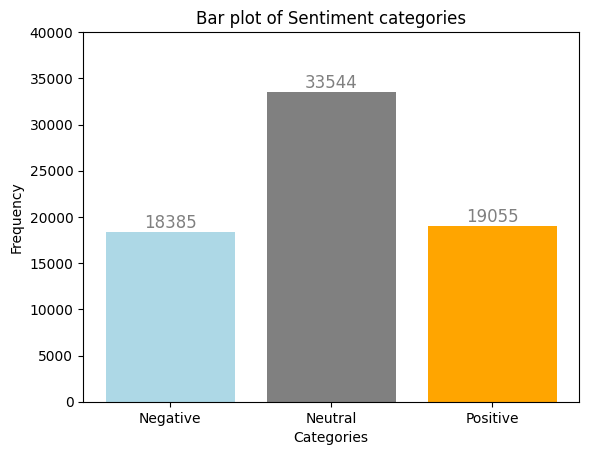

In [9]:
#@markdown ##🐹 🐾 **[8] <font color = 'red'> 감정분석 결과 막대그래프 (부정, 중립, 긍정)**

print('* Negative Flag: ', dfsentiment2['NegFlag'].sum())
print('* Neutral Flag: ', dfsentiment2['NeuFlag'].sum())
print('* Positive Flag: ', dfsentiment2['PosFlag'].sum())
print("="*50)
print('Total: ',dfsentiment2['PosFlag'].sum()+dfsentiment2['NeuFlag'].sum()+dfsentiment2['NegFlag'].sum())


import numpy as np
import matplotlib.pyplot as plt

Negative = int(dfsentiment2['NegFlag'].sum())
Neutral = int(dfsentiment2['NeuFlag'].sum())
Positive = int(dfsentiment2['PosFlag'].sum())

# Your three integer frequencies
freqs = [Negative, Neutral, Positive]
# freqs = [18385, 33544, 19055]

# Create labels for the bars
labels = ['Negative', 'Neutral', 'Positive']

# Create x coordinates for the bars
x = np.arange(len(labels))

# Generate the bar plot
plt.bar(x, freqs)


# Specify the colors for each category
colors = ['lightblue', 'gray', 'orange']

# Generate the bar plot with custom colors

bars = plt.bar(x, freqs, color=colors)
# Add labels to the x-axis
plt.xticks(x, labels)

# Set axis labels
plt.xlabel('Categories')
plt.ylabel('Frequency')

# Set a title for the plot
plt.title('Bar plot of Sentiment categories')
plt.ylim(0, 40000)
# Add the frequency text within each bar
for bar, freq in zip(bars, freqs):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 2, str(freq),
             ha='center', va='bottom', fontsize=12, color='gray')


# Display the plot
plt.show()

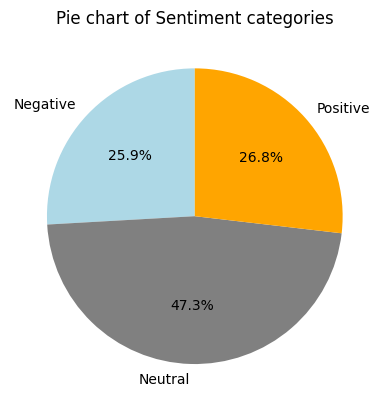

In [8]:
#@markdown ##🐹 🐾 **[9] <font color = 'red'> 감정분석 카테고리 파이차트 (비율확인용)**
import numpy as np
import matplotlib.pyplot as plt

Negative = int(dfsentiment2['NegFlag'].sum())
Neutral = int(dfsentiment2['NeuFlag'].sum())
Positive = int(dfsentiment2['PosFlag'].sum())

# Your three integer frequencies
freqs = [Negative, Neutral, Positive]

# Create labels for the segments
labels = ['Negative', 'Neutral', 'Positive']

# Specify the colors for each segment
colors = ['lightblue', 'gray', 'orange']

# Generate the pie chart with custom colors
plt.pie(freqs, labels=labels, colors=colors, autopct='%.1f%%', startangle=90)

# Set a title for the plot
plt.title('Pie chart of Sentiment categories')

# Display the plot
plt.show()